# Simulation studies using UKB's Indian data

In [1]:
using CSV
using DataFrames
using DelimitedFiles

# helper function to submit 1 job to run 1 command
function submit(command::String, ncores::Int, total_mem::Number, 
        joblog_dir::String="/oak/stanford/groups/zihuai/solveblock/joblogs"; 
        jobname="submit", waitfor=Int[], verbose=true)
    mem = round(Int, total_mem / ncores) # memory per core
    filename = "$jobname.sh"
    open(filename, "w") do io
        println(io, "#!/bin/bash")
        println(io, "#")
        println(io, "#SBATCH --job-name=$jobname")
        println(io, "#")
        println(io, "#SBATCH --time=24:00:00")
        println(io, "#SBATCH --cpus-per-task=$ncores")
        println(io, "#SBATCH --mem-per-cpu=$(mem)G")
        println(io, "#SBATCH --partition=candes,zihuai,normal,owners")
        println(io, "#SBATCH --output=$(joinpath(joblog_dir, "slurm-%j.out"))")
        println(io, "")
        println(io, "#save job info on joblog:")
        println(io, "echo \"Job \$JOB_ID started on:   \" `hostname -s`")
        println(io, "echo \"Job \$JOB_ID started on:   \" `date `")
        println(io, "")
        println(io, "# load the job environment:")
        println(io, "module load julia/1.9")
        println(io, "module load biology plink/1.90b5.3")
        println(io, "module load R/4.0.2")
        println(io, "export OPENBLAS_NUM_THREADS=1")
        println(io, "export JULIA_DEPOT_PATH=\"/home/groups/sabatti/.julia\"")
        println(io, "")
        println(io, "# run code")
        println(io, "echo \"$command\"")
        println(io, "$command")
        println(io, "")
        println(io, "#echo job info on joblog:")
        println(io, "echo \"Job \$JOB_ID ended on:   \" `hostname -s`")
        println(io, "echo \"Job \$JOB_ID ended on:   \" `date `")
        println(io, "#echo \" \"")
    end
    # submit job and capture job ID
    io = IOBuffer()
    if length(waitfor) != 0
        run(pipeline(`sbatch --dependency=afterok:$(join(waitfor, ':')) $filename`; stdout=io))
    else
        run(pipeline(`sbatch $filename`; stdout=io))
    end
    msg = String(take!(io))
    verbose && print(stdout, msg)
    jobid = parse(Int, strip(msg)[21:end])
    # clean up and return job ID
    close(io)
    rm(filename, force=true)
    return jobid
end

# helper function to submit 1 job to run multiple commands
function submit(commands::Vector{String}, ncores::Int, total_mem::Number, 
        joblog_dir::String="/oak/stanford/groups/zihuai/solveblock/joblogs"; 
        jobname="submit", waitfor=Int[], verbose=true)
    mem = round(Int, total_mem / ncores) # memory per core
    filename = "$jobname.sh"
    open(filename, "w") do io
        println(io, "#!/bin/bash")
        println(io, "#")
        println(io, "#SBATCH --job-name=$jobname")
        println(io, "#")
        println(io, "#SBATCH --time=24:00:00")
        println(io, "#SBATCH --cpus-per-task=$ncores")
        println(io, "#SBATCH --mem-per-cpu=$(mem)G")
        println(io, "#SBATCH --partition=candes,zihuai,normal,owners")
        println(io, "#SBATCH --output=$(joinpath(joblog_dir, "slurm-%j.out"))")
        println(io, "")
        println(io, "#save job info on joblog:")
        println(io, "echo \"Job \$JOB_ID started on:   \" `hostname -s`")
        println(io, "echo \"Job \$JOB_ID started on:   \" `date `")
        println(io, "")
        println(io, "# load the job environment:")
        println(io, "module load julia/1.9")
        println(io, "module load biology plink/1.90b5.3")
        println(io, "module load R/4.0.2")
        println(io, "export OPENBLAS_NUM_THREADS=1")
        println(io, "export JULIA_DEPOT_PATH=\"/home/groups/sabatti/.julia\"")
        println(io, "")
        for command in commands
            println(io, "echo \"$command\"")
            println(io, "$command")
        end
        println(io, "")
        println(io, "#echo job info on joblog:")
        println(io, "echo \"Job \$JOB_ID ended on:   \" `hostname -s`")
        println(io, "echo \"Job \$JOB_ID ended on:   \" `date `")
        println(io, "#echo \" \"")
    end
    # submit job and capture job ID
    io = IOBuffer()
    if length(waitfor) != 0
        run(pipeline(`sbatch --dependency=afterok:$(join(waitfor, ':')) $filename`; stdout=io))
    else
        run(pipeline(`sbatch $filename`; stdout=io))
    end
    msg = String(take!(io))
    verbose && print(stdout, msg)
    jobid = parse(Int, strip(msg)[21:end])
    # clean up and return job ID
    close(io)
    rm(filename, force=true)
    return jobid
end


"Run a Cmd object, returning the stdout & stderr contents plus the exit code"
function execute(cmd::Cmd)
    out = Pipe()
    err = Pipe()

    process = run(pipeline(ignorestatus(cmd), stdout=out, stderr=err))
    close(out.in)
    close(err.in)

    return (
        stdout = String(read(out)), 
        stderr = String(read(err)),  
        code = process.exitcode
    )
end

function get_job_names()
    data_str, _, _ = execute(`squeue -u bbchu -h -o "%.30j"`)
    lines = split(data_str, "\n")
    jobnames = String[]
    for line in lines
        push!(jobnames, strip(line))
    end
    return jobnames
end

get_job_names (generic function with 1 method)

## Compute GRM

To run GCTA, we need a GRM

```
cd /scratch/groups/sabatti/ukb_genotypes/indians/gcta_grm
/home/users/bbchu/gcta-1.94.3-linux-kernel-3-x86_64/gcta64 --bfile ../chr10 --make-grm --out chr10

cd /scratch/groups/sabatti/ukb_genotypes/caribbean/gcta_grm
/home/users/bbchu/gcta-1.94.3-linux-kernel-3-x86_64/gcta64 --bfile ../chr10 --make-grm --out chr10

cd /scratch/groups/sabatti/ukb_genotypes/african/gcta_grm
/home/users/bbchu/gcta-1.94.3-linux-kernel-3-x86_64/gcta64 --bfile ../chr10 --make-grm --out chr10

cd /scratch/groups/sabatti/ukb_genotypes/chinese/gcta_grm
/home/users/bbchu/gcta-1.94.3-linux-kernel-3-x86_64/gcta64 --bfile ../chr10 --make-grm --out chr10
```

## Run simulations

Simulation script:

In [ ]:
# put in script /oak/stanford/groups/zihuai/solveblock/fdr_sim_otherpop.jl

seed = parse(Int, ARGS[1])
pop = ARGS[2] # indian, chinese, caribbean, or african

using SnpArrays, Random, CSV, DataFrames, Distributions, StatsBase, GhostKnockoffGWAS
gemma_exe = "/scratch/users/bbchu/gemma-0.98.5-linux-static-AMD64"
gcta_exe = "/home/users/bbchu/gcta-1.94.3-linux-kernel-3-x86_64/gcta64"
LD_files = "/oak/stanford/groups/zihuai/solveblock/LD_files_$pop/default"
datadir = "/scratch/groups/sabatti/ukb_genotypes/$pop"
covfile = "/oak/stanford/groups/zihuai/solveblock/covariates.$pop.csv"
outdir = "/oak/stanford/groups/zihuai/solveblock/sims_$pop"
chr = 10
hg_build = 19

# seed = 123

# some helper functions
function pval2zscore(pvals::AbstractVector{T}, beta::AbstractVector{T}) where T
    length(pvals) == length(beta) || 
        error("pval2zscore: pvals and beta should have the same length")
    return zscore.(pvals, beta)
end
zscore(p::T, beta::T) where T = sign(beta) * quantile(Normal(), p/2)
pval(z::T) where T = 2ccdf(Normal(), abs(z))

# simulation parameters (beta ~ N(mu, sigma))
k = 10
mu = 0
sigma = 0.5

# read covariates
covar = CSV.read(covfile, DataFrame)
C = Matrix(covar[:, 2:end])

# import genotypes
bfile = joinpath(datadir, "chr$(chr)")
xdata = SnpData(bfile)
X = SnpLinAlg{Float64}(xdata.snparray, center=true, scale=true, impute=true)
n, p = size(X)
X_pos = xdata.snp_info.position

# simulate causal beta
Random.seed!(seed)
beta = zeros(p)
for i in 1:k
    beta[i] = rand(Normal(mu, sigma))
end
shuffle!(beta)
causal_snps = findall(!iszero, beta)

# simulate phenotypes, regress out effect of covariates, and normalize it
Random.seed!(seed)
eta = X*beta
y_raw = eta + rand(Normal(0, 3), n)
y = y_raw - C*inv(C'*C)*(C'*y_raw)
zscore!(y, mean(y), std(y))
heritability = var(eta) / var(y_raw)
@show heritability

# run marginal association (score test)
# z = X'*y ./ sqrt(n)
# pvals = pval.(z)

# run LMM (via GCTA)
grm_file = joinpath(datadir, "gcta_grm/chr$chr")
if !isfile(grm_file * ".grm.bin")
    run(`$gcta_exe --bfile $bfile --make-grm --out $grm_file`)
end
pheno_file = joinpath(outdir, "sim$seed.y")
pheno_df = DataFrame("FID"=>xdata.person_info.fid, "IID"=>xdata.person_info.iid,
    "y"=>y)
CSV.write(pheno_file, pheno_df, delim='\t')
outfile = joinpath(outdir, "sim$seed.out")
run(`$gcta_exe --mlma --bfile $bfile --grm $grm_file --pheno $pheno_file --out $outfile --thread-num 1`)
gcta_out = CSV.read(outfile * ".mlma", DataFrame)
gcta_z = pval2zscore(gcta_out.p, gcta_out.b)
for i in eachindex(gcta_z)
    if isinf(gcta_z[i])
        gcta_z[i] = sign(gcta_z[i]) * 20
    end
end

# run GhostKnockoffGWAS
chrs = parse.(Int, xdata.snp_info.chromosome)
pos = xdata.snp_info.position
ref = xdata.snp_info.allele1
alt = xdata.snp_info.allele2
outname = "sim$(seed).lmm"
total_time = @elapsed GhostKnockoffGWAS.ghostknockoffgwas(
    LD_files, gcta_z, chrs, pos, Vector(ref), Vector(alt), n, hg_build, outdir,
    outname = outname, random_shuffle=false, A_scaling_factor=0.01, kappa_lasso=0.6)

# save true beta vector into the GK output
outfile = joinpath(outdir, outname)
GK_df = CSV.read(outfile * ".txt", DataFrame)
GK_df[!, "true_beta"] = beta[indexin(GK_df[!, "pos_hg$(hg_build)"], X_pos)]
CSV.write(outfile * ".txt", GK_df)

# group power/fdr
GK_groups = GK_df[!, "group"]
GK_discover_groups = GK_groups[findall(isone, GK_df[!, "selected_fdr0.1"])]
causal_groups = unique!(GK_groups[findall(!iszero, GK_df.true_beta)])
GK_group_power = length(intersect(GK_discover_groups, causal_groups)) / length(causal_groups)
GK_group_FP = length(setdiff(GK_discover_groups, causal_groups))
GK_group_FDR = GK_group_FP / max(1, length(GK_discover_groups))
println("GK (group) power = $GK_group_power")
println("GK (group) FDR = $GK_group_FDR")

println("\nDone!")

Submit jobs:

In [2]:
exe = "/oak/stanford/groups/zihuai/solveblock/fdr_sim_otherpop.jl"
for pop in ["chinese", "caribbean", "african"] # "indian"
    for sim in 1:200
        submit("julia $exe $sim $pop", 1, 24, jobname="sim$sim")
    end
end

Submitted batch job 61599718
Submitted batch job 61599719
Submitted batch job 61599721
Submitted batch job 61599722
Submitted batch job 61599726
Submitted batch job 61599730
Submitted batch job 61599731
Submitted batch job 61599732
Submitted batch job 61599735
Submitted batch job 61599736
Submitted batch job 61599738
Submitted batch job 61599745
Submitted batch job 61599746
Submitted batch job 61599749
Submitted batch job 61599750
Submitted batch job 61599752
Submitted batch job 61599758
Submitted batch job 61599760
Submitted batch job 61599766
Submitted batch job 61599768
Submitted batch job 61599769
Submitted batch job 61599772
Submitted batch job 61599774
Submitted batch job 61599775
Submitted batch job 61599781
Submitted batch job 61599783
Submitted batch job 61599784
Submitted batch job 61599789
Submitted batch job 61599790
Submitted batch job 61599795
Submitted batch job 61599797
Submitted batch job 61599802
Submitted batch job 61599803
Submitted batch job 61599805
Submitted batc

Submitted batch job 61600264
Submitted batch job 61600265
Submitted batch job 61600266
Submitted batch job 61600267
Submitted batch job 61600268
Submitted batch job 61600269
Submitted batch job 61600270
Submitted batch job 61600271
Submitted batch job 61600272
Submitted batch job 61600273
Submitted batch job 61600274
Submitted batch job 61600275
Submitted batch job 61600276
Submitted batch job 61600277
Submitted batch job 61600278
Submitted batch job 61600279
Submitted batch job 61600280
Submitted batch job 61600281
Submitted batch job 61600282
Submitted batch job 61600283
Submitted batch job 61600284
Submitted batch job 61600285
Submitted batch job 61600287
Submitted batch job 61600288
Submitted batch job 61600289
Submitted batch job 61600291
Submitted batch job 61600299
Submitted batch job 61600302
Submitted batch job 61600324
Submitted batch job 61600327
Submitted batch job 61600330
Submitted batch job 61600383
Submitted batch job 61600386
Submitted batch job 61600387
Submitted batc

Submitted batch job 61600702
Submitted batch job 61600703
Submitted batch job 61600704
Submitted batch job 61600705
Submitted batch job 61600706
Submitted batch job 61600709
Submitted batch job 61600710
Submitted batch job 61600711
Submitted batch job 61600712
Submitted batch job 61600713
Submitted batch job 61600714
Submitted batch job 61600715
Submitted batch job 61600716
Submitted batch job 61600717
Submitted batch job 61600718
Submitted batch job 61600719
Submitted batch job 61600723
Submitted batch job 61600727
Submitted batch job 61600730
Submitted batch job 61600733
Submitted batch job 61600736
Submitted batch job 61600738
Submitted batch job 61600742
Submitted batch job 61600743
Submitted batch job 61600745
Submitted batch job 61600750
Submitted batch job 61600753
Submitted batch job 61600755
Submitted batch job 61600758
Submitted batch job 61600760
Submitted batch job 61600762
Submitted batch job 61600765
Submitted batch job 61600767
Submitted batch job 61600768


## Power vs FDR plot

In [4]:
using Plots
using ProgressMeter

global titlefontsize=10
global legendfontsize=10
global labelfontsize=10
global annotationfontsize=10
global guidefontsize=10

function make_plot(pop, power::Vector{Float64}, obs_fdr::Vector{Float64}, tgt_fdr::Vector{Float64})
    title = uppercase(pop[1]) * pop[2:end]
    power_plt = plot(tgt_fdr, power; xtick=false, ylim=(0, 1.0), ylabel="Power",
        legend=false, left_margin = 5Plots.mm, titlefontsize=titlefontsize,
        guidefontsize=guidefontsize, labelfontsize=labelfontsize, w=3, title=title)
    fdr_plt = plot(tgt_fdr, obs_fdr; xlabel="target FDR", ylim=(0, 0.25), ylabel="obs FDR", legend=false, 
        xgrid=false, left_margin = 5Plots.mm, guidefontsize=guidefontsize,
        labelfontsize=labelfontsize, w=3)
    Plots.abline!(fdr_plt, 1, 0, alpha=0.3, w=2, linestyle=:dot, color=:black)
    return plot(power_plt, fdr_plt, layout = grid(2, 1, heights=[0.7 ,0.3]), fmt=:png)
end

function summarize_result(pop, seeds, tgt_fdr::Vector{Float64})
    powers = zeros(length(tgt_fdr))
    fdr = zeros(length(tgt_fdr))
    successes = 0
    @showprogress for seed in seeds
        try
            GK_df = CSV.read("/oak/stanford/groups/zihuai/solveblock/sims_$pop/sim$seed.lmm.txt", DataFrame)
            qvals = GK_df[!, "qvals"]
            beta = GK_df[!, "true_beta"]
            GK_groups = GK_df[!, "group"]
            causal_groups = unique!(GK_groups[findall(!iszero, beta)])
            for (i, threshold) in enumerate(tgt_fdr)
                GK_discover_snps = findall(x -> x < threshold, qvals)
                GK_discover_groups = unique!(GK_groups[GK_discover_snps])
                GK_group_power = length(intersect(GK_discover_groups, causal_groups)) / length(causal_groups)
                GK_group_FDR = length(setdiff(GK_discover_groups, causal_groups)) / max(1, length(GK_discover_groups))
                powers[i] += GK_group_power
                fdr[i] += GK_group_FDR
            end
            successes += 1
        catch
            continue
        end
    end
    @show successes
    powers ./= successes
    fdr ./= successes
    return powers, fdr
end

summarize_result (generic function with 1 method)

## Mixed model test

Progress: 100%|█████████████████████████████████████████| Time: 0:00:21


successes = 200


Progress: 100%|█████████████████████████████████████████| Time: 0:00:14


successes = 200


Progress: 100%|█████████████████████████████████████████| Time: 0:00:14


successes = 200


Progress: 100%|█████████████████████████████████████████| Time: 0:00:14


successes = 200


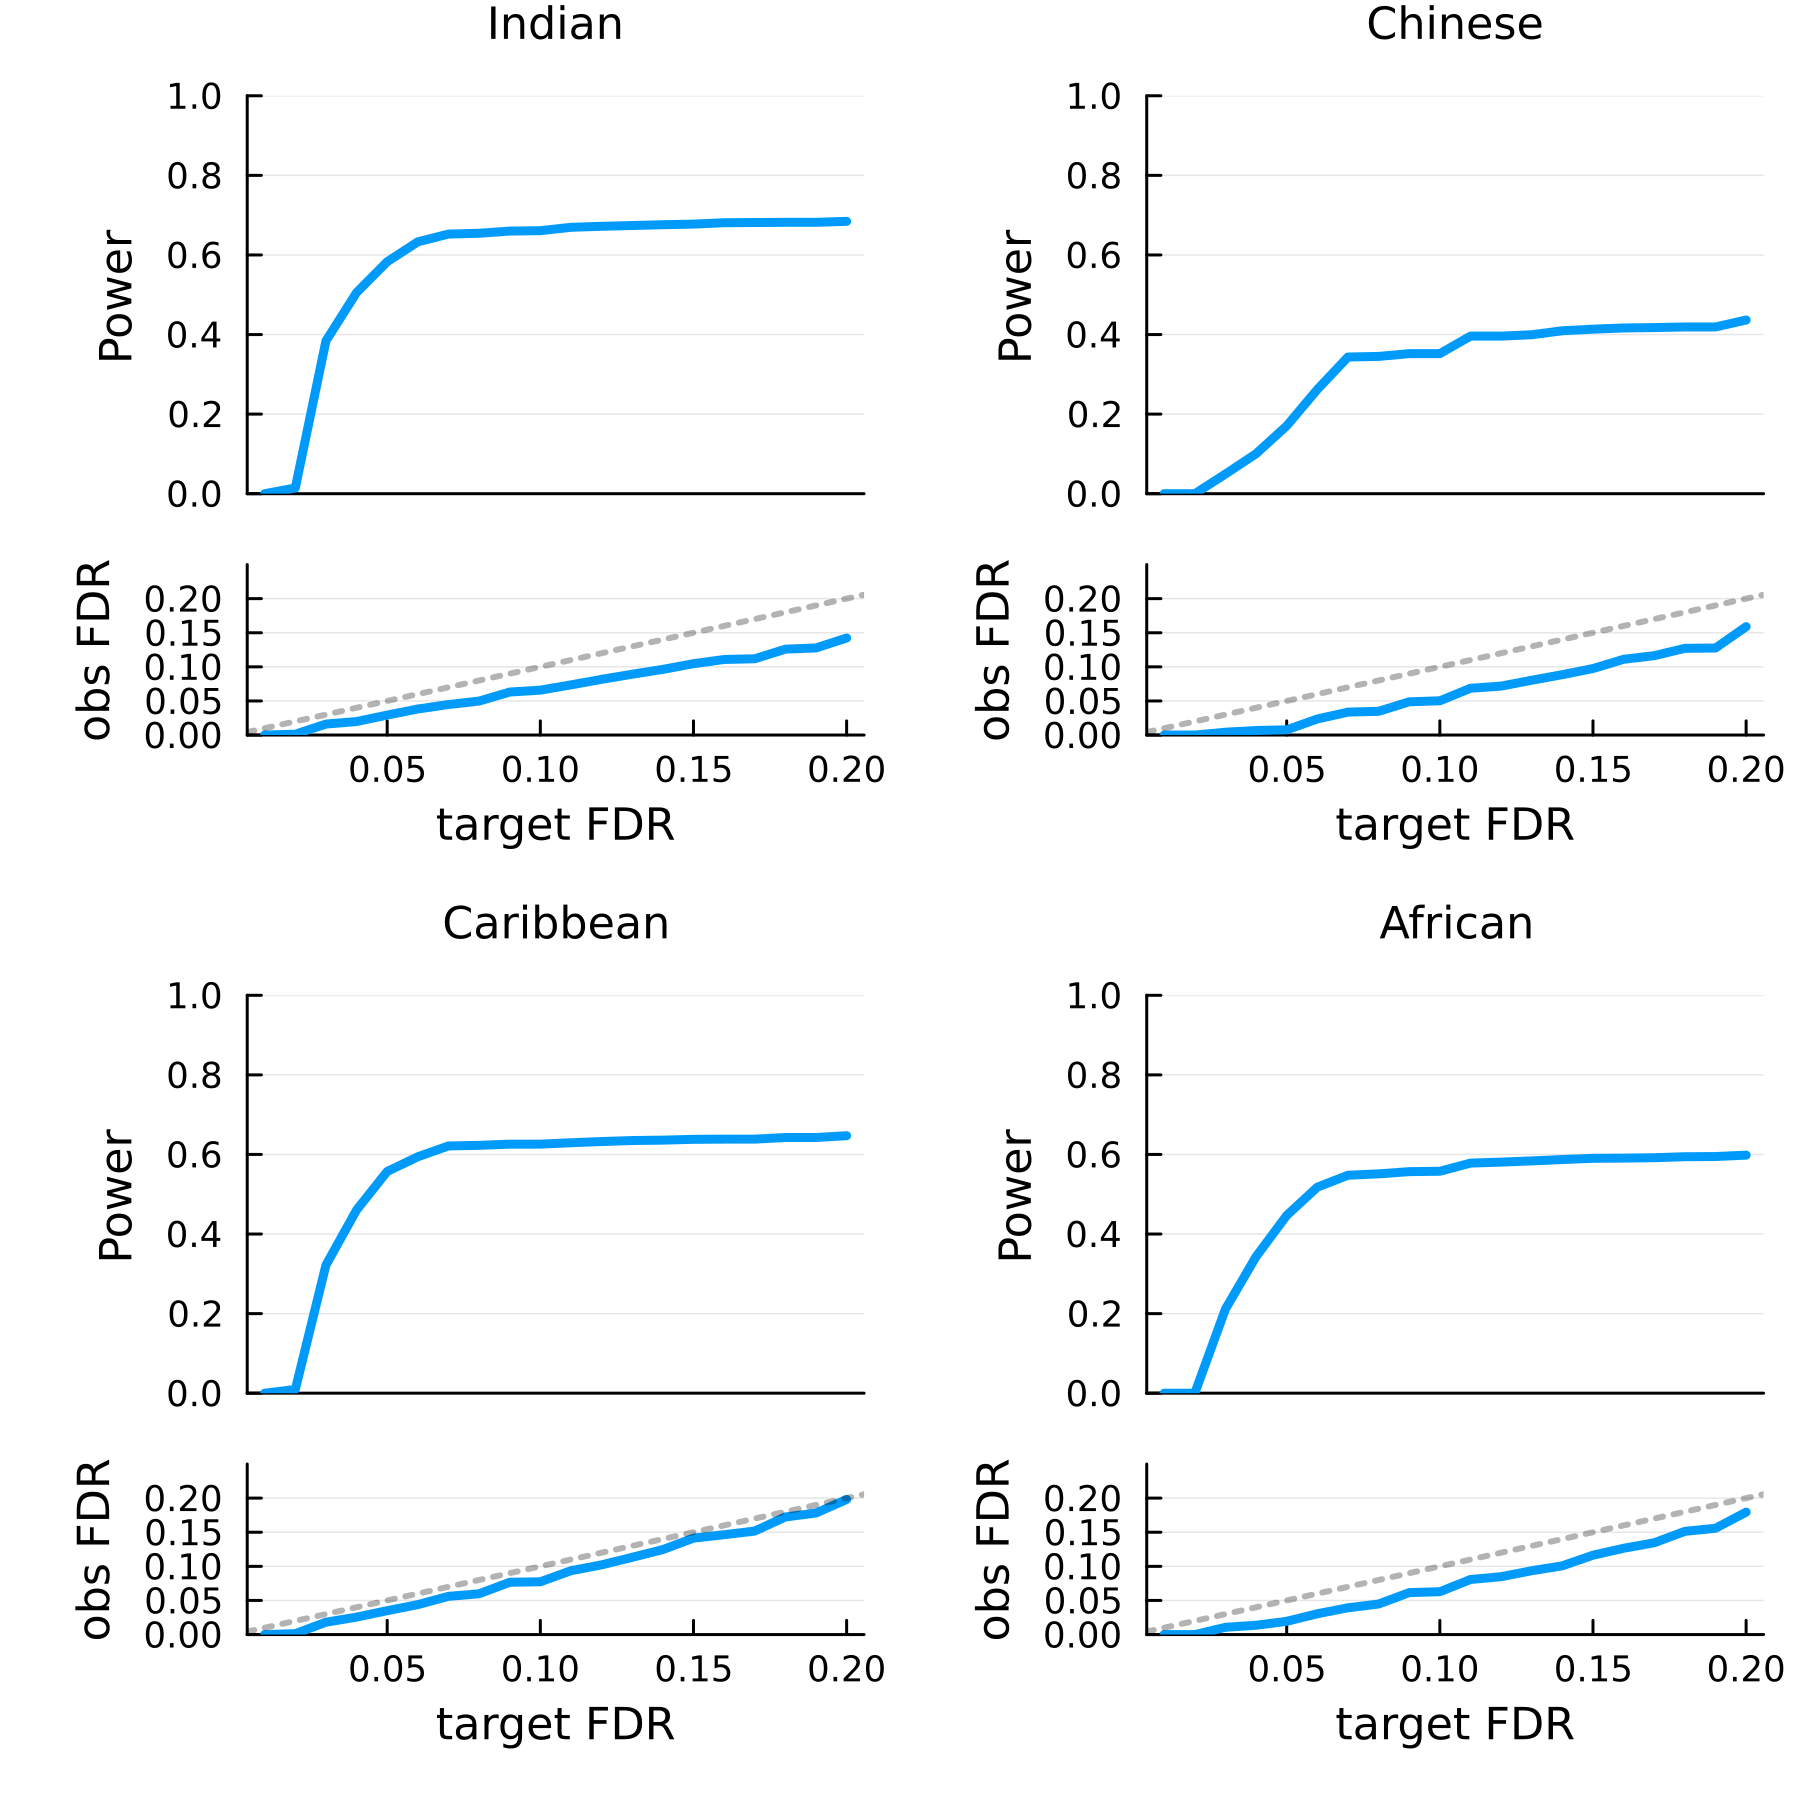

In [8]:
# beta ~ N(0, 0.5) chr10
sims = 1:200
plts = []
for pop in ["indian", "chinese", "caribbean", "african"]
    target_fdr = collect(0.01:0.01:0.2)
    power, fdr = summarize_result(pop, sims, target_fdr)
    plt = make_plot(pop, power, fdr, target_fdr)
    plt = plot(plt, dpi=300, size=(300, 300))
    push!(plts, plt)
end
plot(plts..., size=(600, 600))